In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

# Import custom modules
import feature_extraction as fe
import models
import evaluation as ev
import augmentation as aug

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [2]:
# 1. Data Configuration
# ====================

# Define paths
video_path = 'data/videos'  # Path to the video dataset
models_path = 'models' 
# Define the sign language words/gestures to recognize
WORDS = os.listdir(video_path)
num_classes = len(WORDS)

In [3]:
WORDS, num_classes

(['apple',
  'ball',
  'bird',
  'black',
  'candy',
  'color',
  'cousin',
  'forget',
  'hearing',
  'mother',
  'no',
  'now',
  'orange',
  'water',
  'wrong',
  'yes'],
 16)

In [4]:
# Create directories if they don't exist
os.makedirs(models_path, exist_ok=True)

In [5]:
# Configuration parameters
sequence_length = 30  # Number of frames to use from each video
test_size = 0.2       # Proportion of data to use for testing
random_state = 42     # Random seed for reproducible splits

In [6]:
# 2. Data Loading and Preprocessing
# ================================

print("Step 1: Loading and preprocessing video data...")

# Check if processed data already exists
# import pickle
# data_file = 'data/processed_data.pkl'

# if os.path.exists(data_file):
#     print("Loading preprocessed data from file...")
#     with open(data_file, 'rb') as f:
#         data = pickle.load(f)
#     X_raw, y = data['X_raw'], data['y']
# else:
#     print("Processing video data...")
#     # Process all videos
#     X_raw, y = dp.process_all_videos(video_path, words, sequence_length)
    
#     # Save processed data
#     os.makedirs('data', exist_ok=True)
#     with open(data_file, 'wb') as f:
#         pickle.dump({'X_raw': X_raw, 'y': y}, f)

X_raw = np.load('data/X_raw.npy')
y = np.load('data/y.npy')

print(f"Loaded {len(X_raw)} video sequences with shape {X_raw.shape}")
print(f"Loaded {len(y)} video labels with shape {y.shape}")

Step 1: Loading and preprocessing video data...
Loaded 187 video sequences with shape (187, 30, 42, 3)
Loaded 187 video labels with shape (187,)


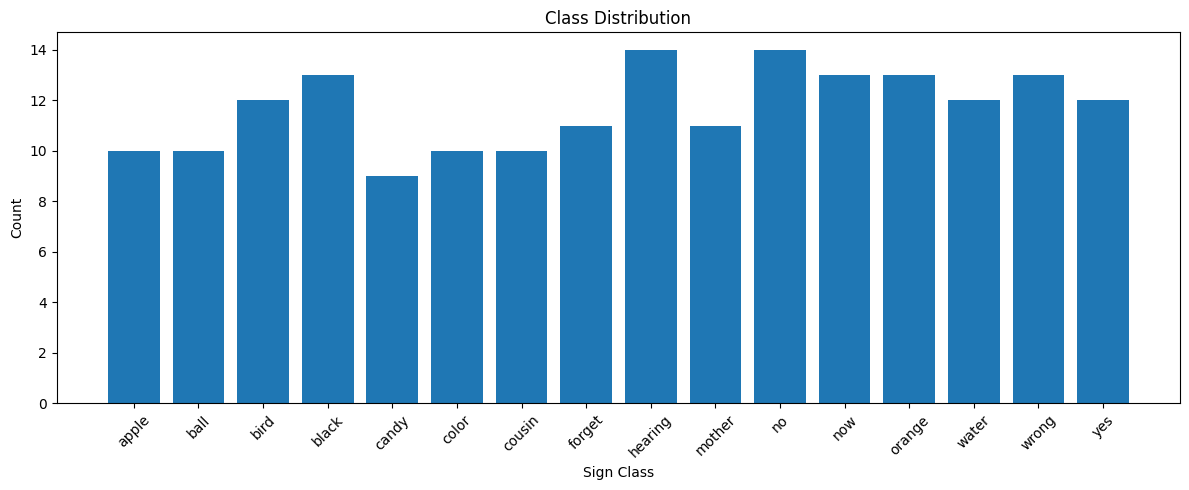

In [7]:
# Display class distribution
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(12, 5))
plt.bar([WORDS[i] for i in unique], counts)
plt.title('Class Distribution')
plt.xlabel('Sign Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Step 2: Augmenting the dataset...
(149, 30, 42, 3) (38, 30, 42, 3) (149,) (38,)
Generating Augmented data
Original train dataset size: 149
Augmented train dataset size: 596


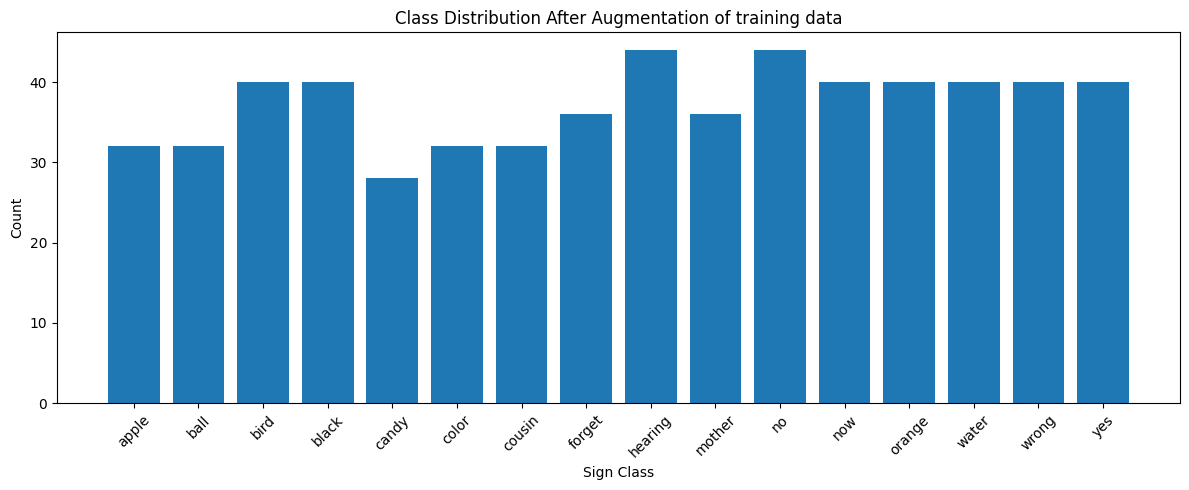

In [8]:
# 3. Data Augmentation
# ===================

print("Step 2: Augmenting the dataset...")

# Split raw sequences BEFORE augmentation
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42) 
print(X_train_raw.shape, X_test_raw.shape, y_train_raw.shape, y_test.shape)

# Apply augmentation ONLY to the training set
X_train_aug, y_train_aug = aug.generate_augmented_dataset(X_train_raw, y_train_raw)

print(f"Original train dataset size: {len(X_train_raw)}")
print(f"Augmented train dataset size: {len(X_train_aug)}")
# No augmentation for test set
X_test_aug, y_test_aug = X_test_raw, y_test
# X_test_aug, y_test_aug = generate_augmented_dataset(X_test_raw, y_test)

# Display class distribution after augmentation
unique_aug, counts_aug = np.unique(y_train_aug, return_counts=True)
plt.figure(figsize=(12, 5))
plt.bar([WORDS[i] for i in unique_aug], counts_aug)
plt.title('Class Distribution After Augmentation of training data')
plt.xlabel('Sign Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
print("Extracting Train Data Features")
X_train_features = np.array([fe.extract_features_3d(seq) for seq in X_train_aug])
print("Extracting Test Data Features")
X_test_features = np.array([fe.extract_features_3d(seq) for seq in X_test_aug])

X_train_features.shape  # (num_train_samples, num_features)
X_test_features.shape   # (num_test_samples, num_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

Extracting Train Data Features
Extracting Test Data Features


In [10]:
X_train_scaled.shape

(596, 1134)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.layers import Masking, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# 6. Classical Machine Learning Models
# ==================================

print("Step 4: Training classical machine learning models...")

# --- CLASSIFIERS ---
print('Training Neural Network')

print('Training Logistic Regression')
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(X_train_scaled, y_train_aug)

print('Training Random Forest')
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_aug)

print('Training SVM')
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train_aug)

Step 4: Training classical machine learning models...
Training Neural Network
Training Logistic Regression
Training Random Forest
Training SVM


SVC(probability=True)

Evaluating Models

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         2
           3       0.33      0.33      0.33         3
           4       1.00      0.50      0.67         2
           5       0.67      1.00      0.80         2
           6       1.00      0.50      0.67         2
           7       0.33      0.50      0.40         2
           8       0.67      0.67      0.67         3
           9       0.00      0.00      0.00         2
          10       1.00      0.67      0.80         3
          11       0.75      1.00      0.86         3
          12       0.50      0.33      0.40         3
          13       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         3
          15       0.40      1.00      0.57         2

    accuracy     

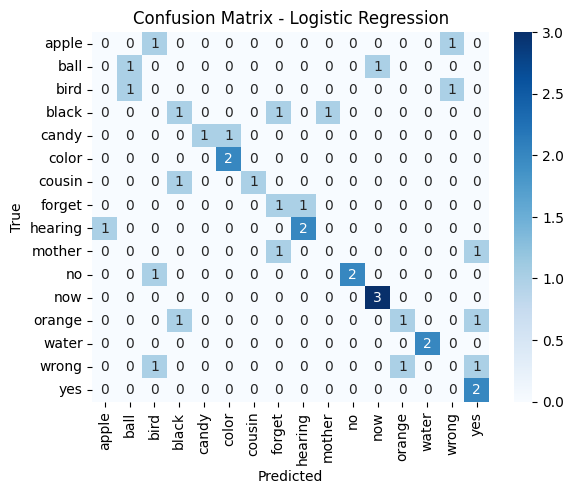


Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.50      1.00      0.67         2
           5       0.00      0.00      0.00         2
           6       0.33      0.50      0.40         2
           7       0.33      0.50      0.40         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          10       0.67      0.67      0.67         3
          11       0.75      1.00      0.86         3
          12       0.33      0.33      0.33         3
          13       0.67      1.00      0.80         2
          14       0.00      0.00      0.00         3
          15       0.50      1.00      0.67         2

    accuracy                           0.

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

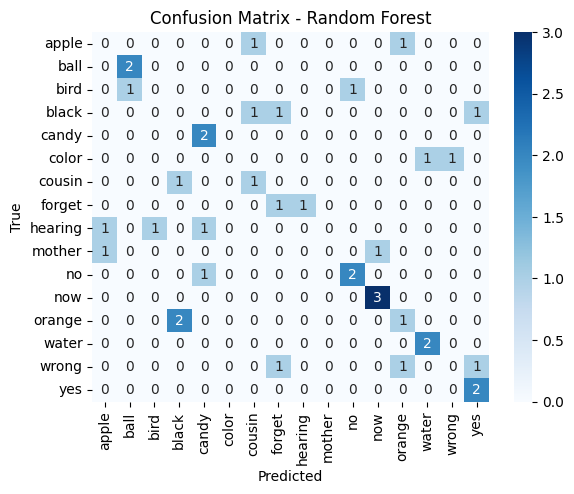


SVM Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       1.00      0.50      0.67         2
           7       0.50      0.50      0.50         2
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          10       1.00      0.67      0.80         3
          11       0.50      1.00      0.67         3
          12       0.00      0.00      0.00         3
          13       0.33      1.00      0.50         2
          14       0.00      0.00      0.00         3
          15       0.67      1.00      0.80         2

    accuracy                           0.29        

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

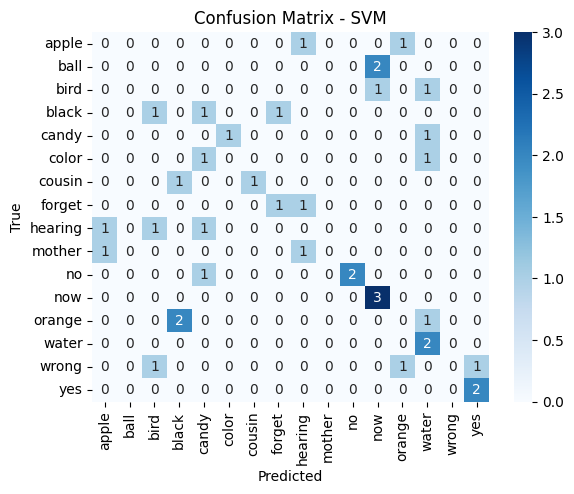

In [13]:
# --- EVALUATION ---
def evaluate(model, name):
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test_aug, y_pred))
    cm = confusion_matrix(y_test_aug, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=WORDS, yticklabels=WORDS)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    
print('Evaluating Models')
evaluate(lr_model, "Logistic Regression")
evaluate(rf_model, "Random Forest")
evaluate(svm_model, "SVM")

In [14]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

Step 5: Training MLP neural network...


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


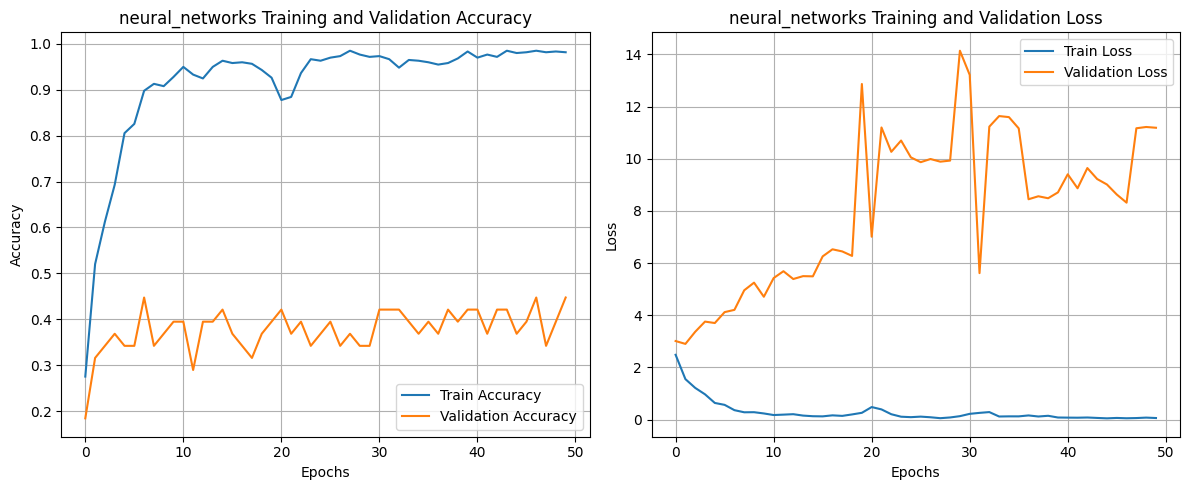

In [15]:
# 7. Simple MLP Model
# =================

print("Step 5: Training MLP neural network...")

# Compute class weights for imbalanced data
class_weights = models.compute_class_weights(y_train_aug)
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(set(y)), activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_nn = nn_model.fit(X_train_scaled, y_train_aug, validation_data=(X_test_scaled, y_test_aug), epochs=50, batch_size=8, verbose=0)


# Plot training history
plot_history(history_nn, 'neural_networks')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.20      0.50      0.29         2
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         2
           5       0.67      1.00      0.80         2
           6       0.50      0.50      0.50         2
           7       0.50      0.50      0.50         2
           8       0.67      0.67      0.67         3
           9       0.00      0.00      0.00         2
          10       1.00      0.67      0.80         3
          11       0.38      1.00      0.55         3
          12       0.33      0.33      0.33         3
          13       1.00      1.00      1.00         2
          14       0.00      0.00      0.00         3
          15       0.67      1.00      0.80         2

  

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

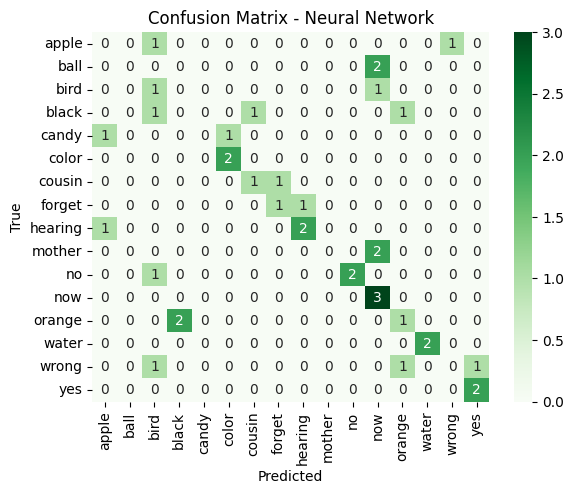

In [16]:
nn_preds = np.argmax(nn_model.predict(X_test_scaled), axis=1)
print("\nNeural Network Classification Report:\n")
print(classification_report(y_test_aug, nn_preds))
cm_nn = confusion_matrix(y_test_aug, nn_preds)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens', xticklabels=WORDS, yticklabels=WORDS)
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('neural_network_training_history.png')
plt.show()

## LSTM

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
# 8. Sequence-Based Models (LSTM)
# =============================

print("Step 6: Preparing data for sequence-based models...")

# Prepare data for LSTM
X_lstm = X_raw.reshape((X_raw.shape[0], X_raw.shape[1], -1))  # (147, 30, 126)

# Load or create labels
num_classes = len(WORDS)
y_lstm = y

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_lstm)

# Normalize features
X_normalized = np.zeros_like(X_lstm)
for i in range(X_lstm.shape[0]):
    # Normalize each sample to have zero mean and unit variance
    X_normalized[i] = (X_lstm[i] - np.mean(X_lstm[i])) / (np.std(X_lstm[i]) + 1e-8)

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_normalized, y_encoded, test_size=0.2, random_state=42)

# Augment training data for LSTM
X_train_lstm_aug, y_train_lstm_aug = aug.augment_lstm_data(X_train_lstm, y_train_lstm)

print(f"LSTM data shapes:")
print(f"Training: {X_train_lstm_aug.shape}, {y_train_lstm_aug.shape}")
print(f"Testing: {X_test_lstm.shape}, {y_test_lstm.shape}")

Step 6: Preparing data for sequence-based models...
🔁 Augmenting LSTM-compatible data...
LSTM data shapes:
Training: (596, 30, 126), (596,)
Testing: (38, 30, 126), (38,)


Step 7: Training LSTM model...


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 30, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 512)        │       784,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,634,512 (6.24 MB)

 Trainable params: 1,632,720 (6.23 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 283ms/step - accuracy: 0.0617 - loss: 3.1823 - val_accuracy: 0.1579 - val_loss: 2.8793 - learning_rate: 2.0000e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.2039 - loss: 2.6558 - val_accuracy: 0.2895 - val_loss: 2.7347 - learning_rate: 4.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.2697 - loss: 2.4091 - val_accuracy: 0.2632 - val_loss: 2.5813 - learning_rate: 6.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.3144 - loss: 2.2801 - val_accuracy: 0.4211 - val_loss: 2.3357 - learning_rate: 8.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.3789 - loss: 2.0314 - val_accuracy: 0.3158 - val_loss: 2.2130 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.3619 - loss: 2.0002 - val_accuracy: 0.3947 - val_loss: 1.9181 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 356ms/step - accuracy:

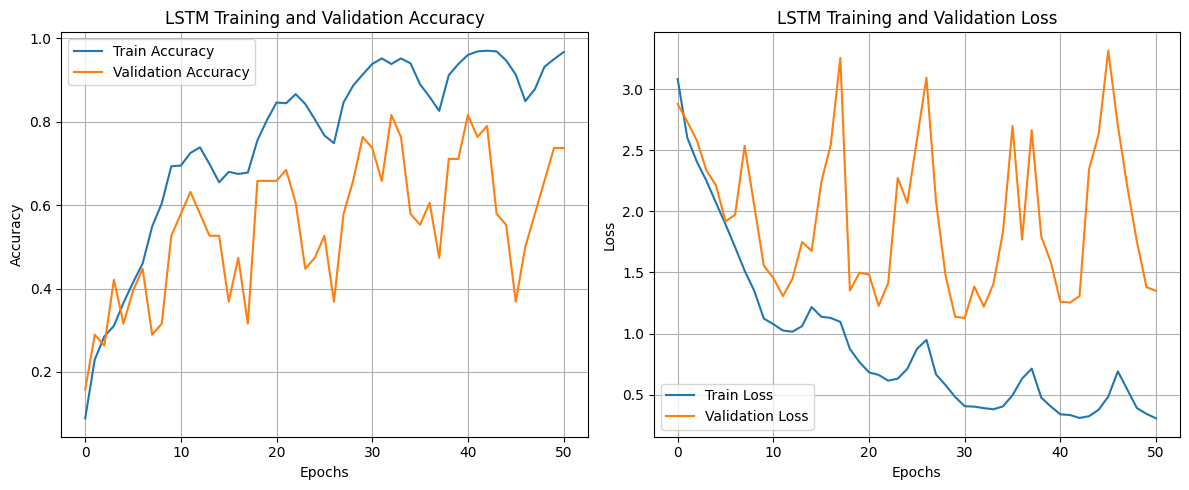

In [19]:
# 9. LSTM Model
# ===========

print("Step 7: Training LSTM model...")

# Build LSTM model
lstm_model = Sequential([
        # Masking layer for any padded sequences
        Masking(mask_value=0., input_shape=(sequence_length, 126)),
        
        # First bidirectional LSTM layer
        Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Second bidirectional LSTM layer
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third bidirectional LSTM layer
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        
        # Fully connected layers
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
optimizer = Adam(learning_rate=0.0005)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lstm_model.summary()

# Compute class weights for LSTM
lstm_class_weights = models.compute_class_weights(y_train_lstm_aug)

# Train LSTM model
callbacks = models.get_callbacks()
history_lstm = lstm_model.fit(
    X_train_lstm_aug, y_train_lstm_aug,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    class_weight=lstm_class_weights,
    verbose=1
)

# Plot LSTM training history
plot_history(history_lstm, 'LSTM')
lstm_model.save('models/lstm_model.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      0.50      0.67         2
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         2
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         0
          10       0.67      1.00      0.80         2
          11       1.00      1.00      1.00         2
          12       0.75      0.75      0.75         4
          13       0.75      0.75      0.75         4
          14       1.00      1.00      1.00         4
          15       1.00      0.33      0.50         3

    accuracy   

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

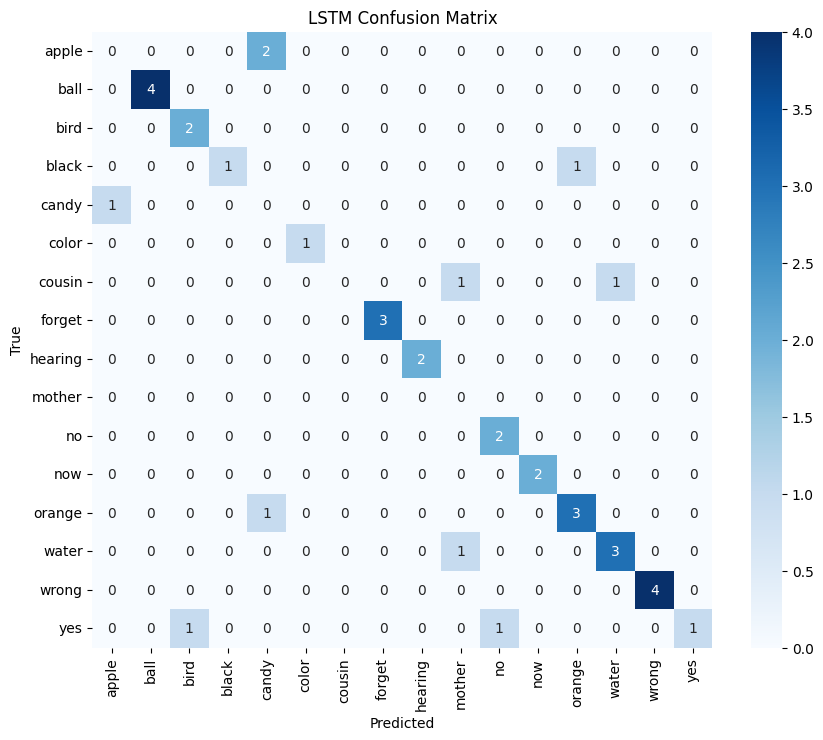

In [20]:
y_pred = lstm_model.predict(X_test_lstm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nLSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_lstm, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=WORDS, yticklabels=WORDS)
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('lstm_confusion_matrix.png')
plt.show()

Step 8: Training CNN-LSTM hybrid model...


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,352 (618.56 KB)

 Trainable params: 157,712 (616.06 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1508 - loss: 2.8952 - val_accuracy: 0.2895 - val_loss: 2.6129 - learning_rate: 5.0000e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4850 - loss: 1.6996 - val_accuracy: 0.3684 - val_loss: 2.4208 - learning_rate: 5.0000e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6599 - loss: 1.2956 - val_accuracy: 0.5000 - val_loss: 2.1521 - learning_rate: 5.0000e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7468 - loss: 0.9632 - val_accuracy: 0.5526 - val_loss: 1.9132 - learning_rate: 5.0000e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8037 - loss: 0.7813 - val_accuracy: 0.4211 - val_loss: 1.8889 - learning_rate: 5.0000e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8727 - loss: 0.6159 - val_accuracy: 0.4211 - val_loss: 1.7526 - learning_rate: 5.0000e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy:

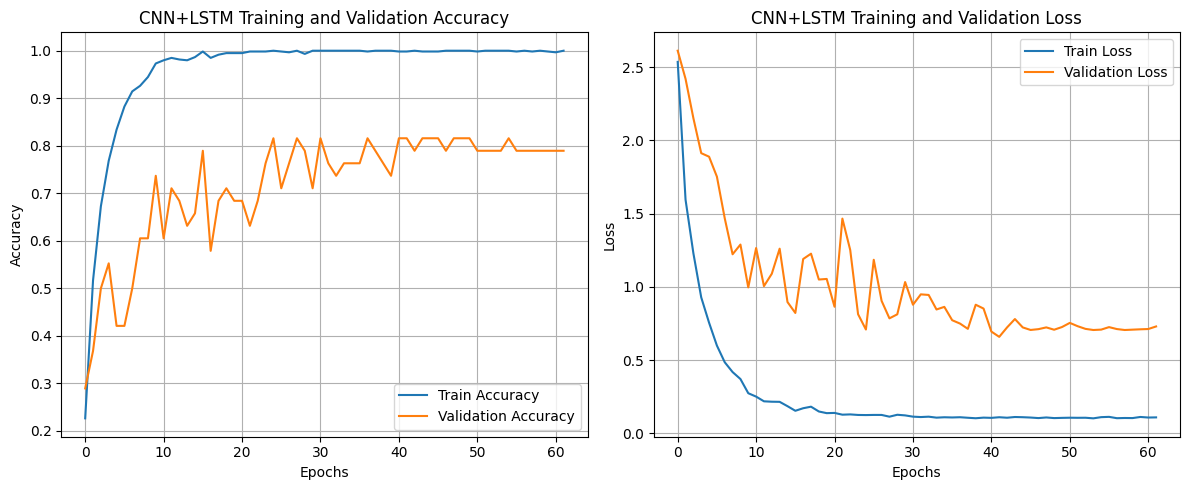

In [21]:

# 10. CNN-LSTM Hybrid Model
# =======================
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True,
    verbose=1
)
def cosine_decay_with_warmup(epoch, total_epochs=100, warmup_epochs=5):
    if epoch < warmup_epochs:
        # Linear warmup
        return (epoch + 1) / warmup_epochs * 0.001
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 0.0001 + 0.0009 * 0.5 * (1 + np.cos(np.pi * progress))
    
lr_scheduler = LearningRateScheduler(cosine_decay_with_warmup)

# Also keep ReduceLROnPlateau as backup
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("Step 8: Training CNN-LSTM hybrid model...")

# Build CNN-LSTM model
cnn_lstm_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 126)),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
optimizer = Adam(learning_rate=0.0005)
cnn_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
cnn_lstm_model.summary()

# Train CNN-LSTM model
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_lstm_aug, y_train_lstm_aug,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    class_weight=lstm_class_weights,
    verbose=1
)

# Plot CNN-LSTM training history
plot_history(history_cnn_lstm, 'CNN+LSTM')
cnn_lstm_model.save('models/cnn_lstm_model.keras')

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A6D637A8E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step

CNN-LSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.75      0.86         4
 

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

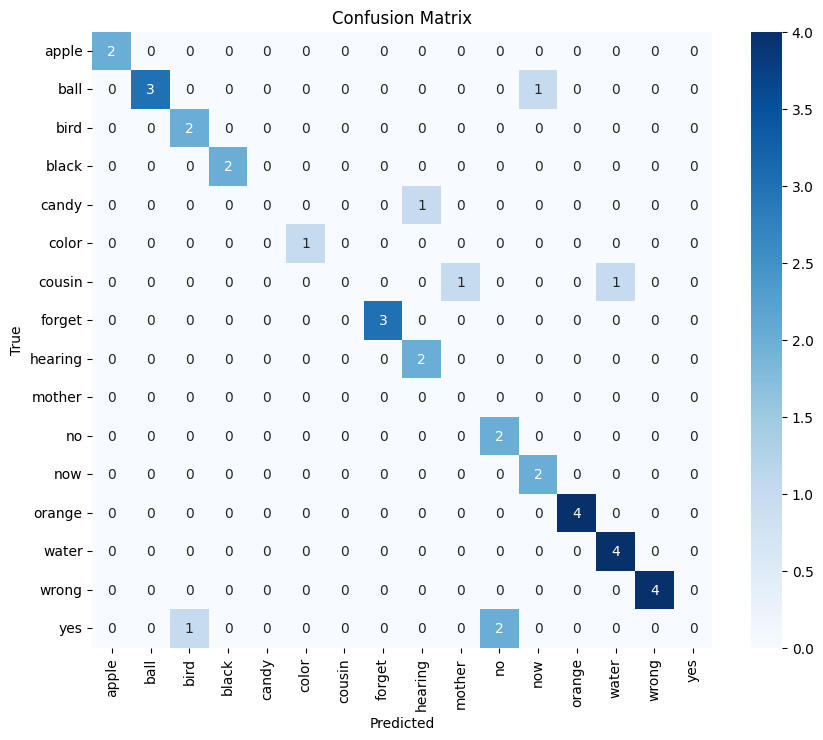

In [22]:
# Evaluate CNN-LSTM model
y_cnn_lstm_pred = cnn_lstm_model.predict(X_test_lstm)
y_cnn_lstm_classes = np.argmax(y_cnn_lstm_pred, axis=1)
print("\nCNN-LSTM Classification Report:")
print(classification_report(y_test_lstm, y_cnn_lstm_classes))
# Confusion matrix
conf_matrix = confusion_matrix(y_test_lstm, y_cnn_lstm_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=WORDS, yticklabels=WORDS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('confusion_matrix.png')
plt.show()

In [23]:

# # 11. Cross-Validation for Best Model
# # =================================

# print("Step 9: Running cross-validation on best model...")

# # Run cross-validation on the best model (update with your best model)
# best_model_builder = models.build_lstm_model  # Change based on your results
# cv_scores = ev.run_cross_validation(
#     X_lstm, y_lstm, 
#     model_builder=best_model_builder,
#     n_splits=5, 
#     epochs=50, 
#     batch_size=32,
#     words=WORDS,
#     sequence_length=sequence_length,
#     num_features=X_lstm.shape[2]
# )